- https://www.tensorflow.org/tutorials/structured_data/time_series

# input: 
- temp
- snow
- price
- area

# output
- price x days in advance

# What to do:
- time series for max day price
- regression per day (feat: days out, weather)

In [25]:
# dependencies
!pip install statsmodels pandas matplotlib seaborn pmdarima scikit-learn

In [81]:
import sys
sys.path.append('..') # Add parent directory to path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from pmdarima.arima import auto_arima
from lib import add_axis_mondays
from sklearn.metrics import mean_squared_error

In [49]:
import warnings
warnings.filterwarnings('ignore')

In [31]:
# load data
ds = pd.read_csv('ds/ds.csv', parse_dates=True, index_col=0)

In [ ]:
# Visual representation of used the dataset
fig = plt.figure(figsize=(40, 20))
groups = ds.groupby("resort")

for index, (resort, group) in enumerate(groups):
    axis = fig.add_subplot(
        len(groups),1,index+1,
        yticks=[],
        title=resort
    )
    axis.plot(group.index, group["max_price"])
    for index, (col, color) in enumerate([
        ('price_surge', 'black'),
        ('sunnyness', 'orange'),
        ('avg_temp', 'purple'),
        ('sum_snow', 'g'),
        ('avg_percipitation', 'b')
    ]):
        ax = axis.twinx()
        ax.plot(group.index, group[col], color=color)
        if index > 0:
            ax.set_yticks([])
            sax = ax.secondary_yaxis(1.0 + 0.04 * (index - 1))
            sax.set_ylabel(col, color=color)
            sax.tick_params(axis='y', labelcolor=color)
        else:
            ax.yaxis.set_ticks_position("left")
            ax.yaxis.set_label_position("left")
            ax.set_ylabel('snow_depth', color=color)
            ax.tick_params(axis='y', labelcolor=color)

/tmp/ipykernel_94665/1523130403.py:65: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


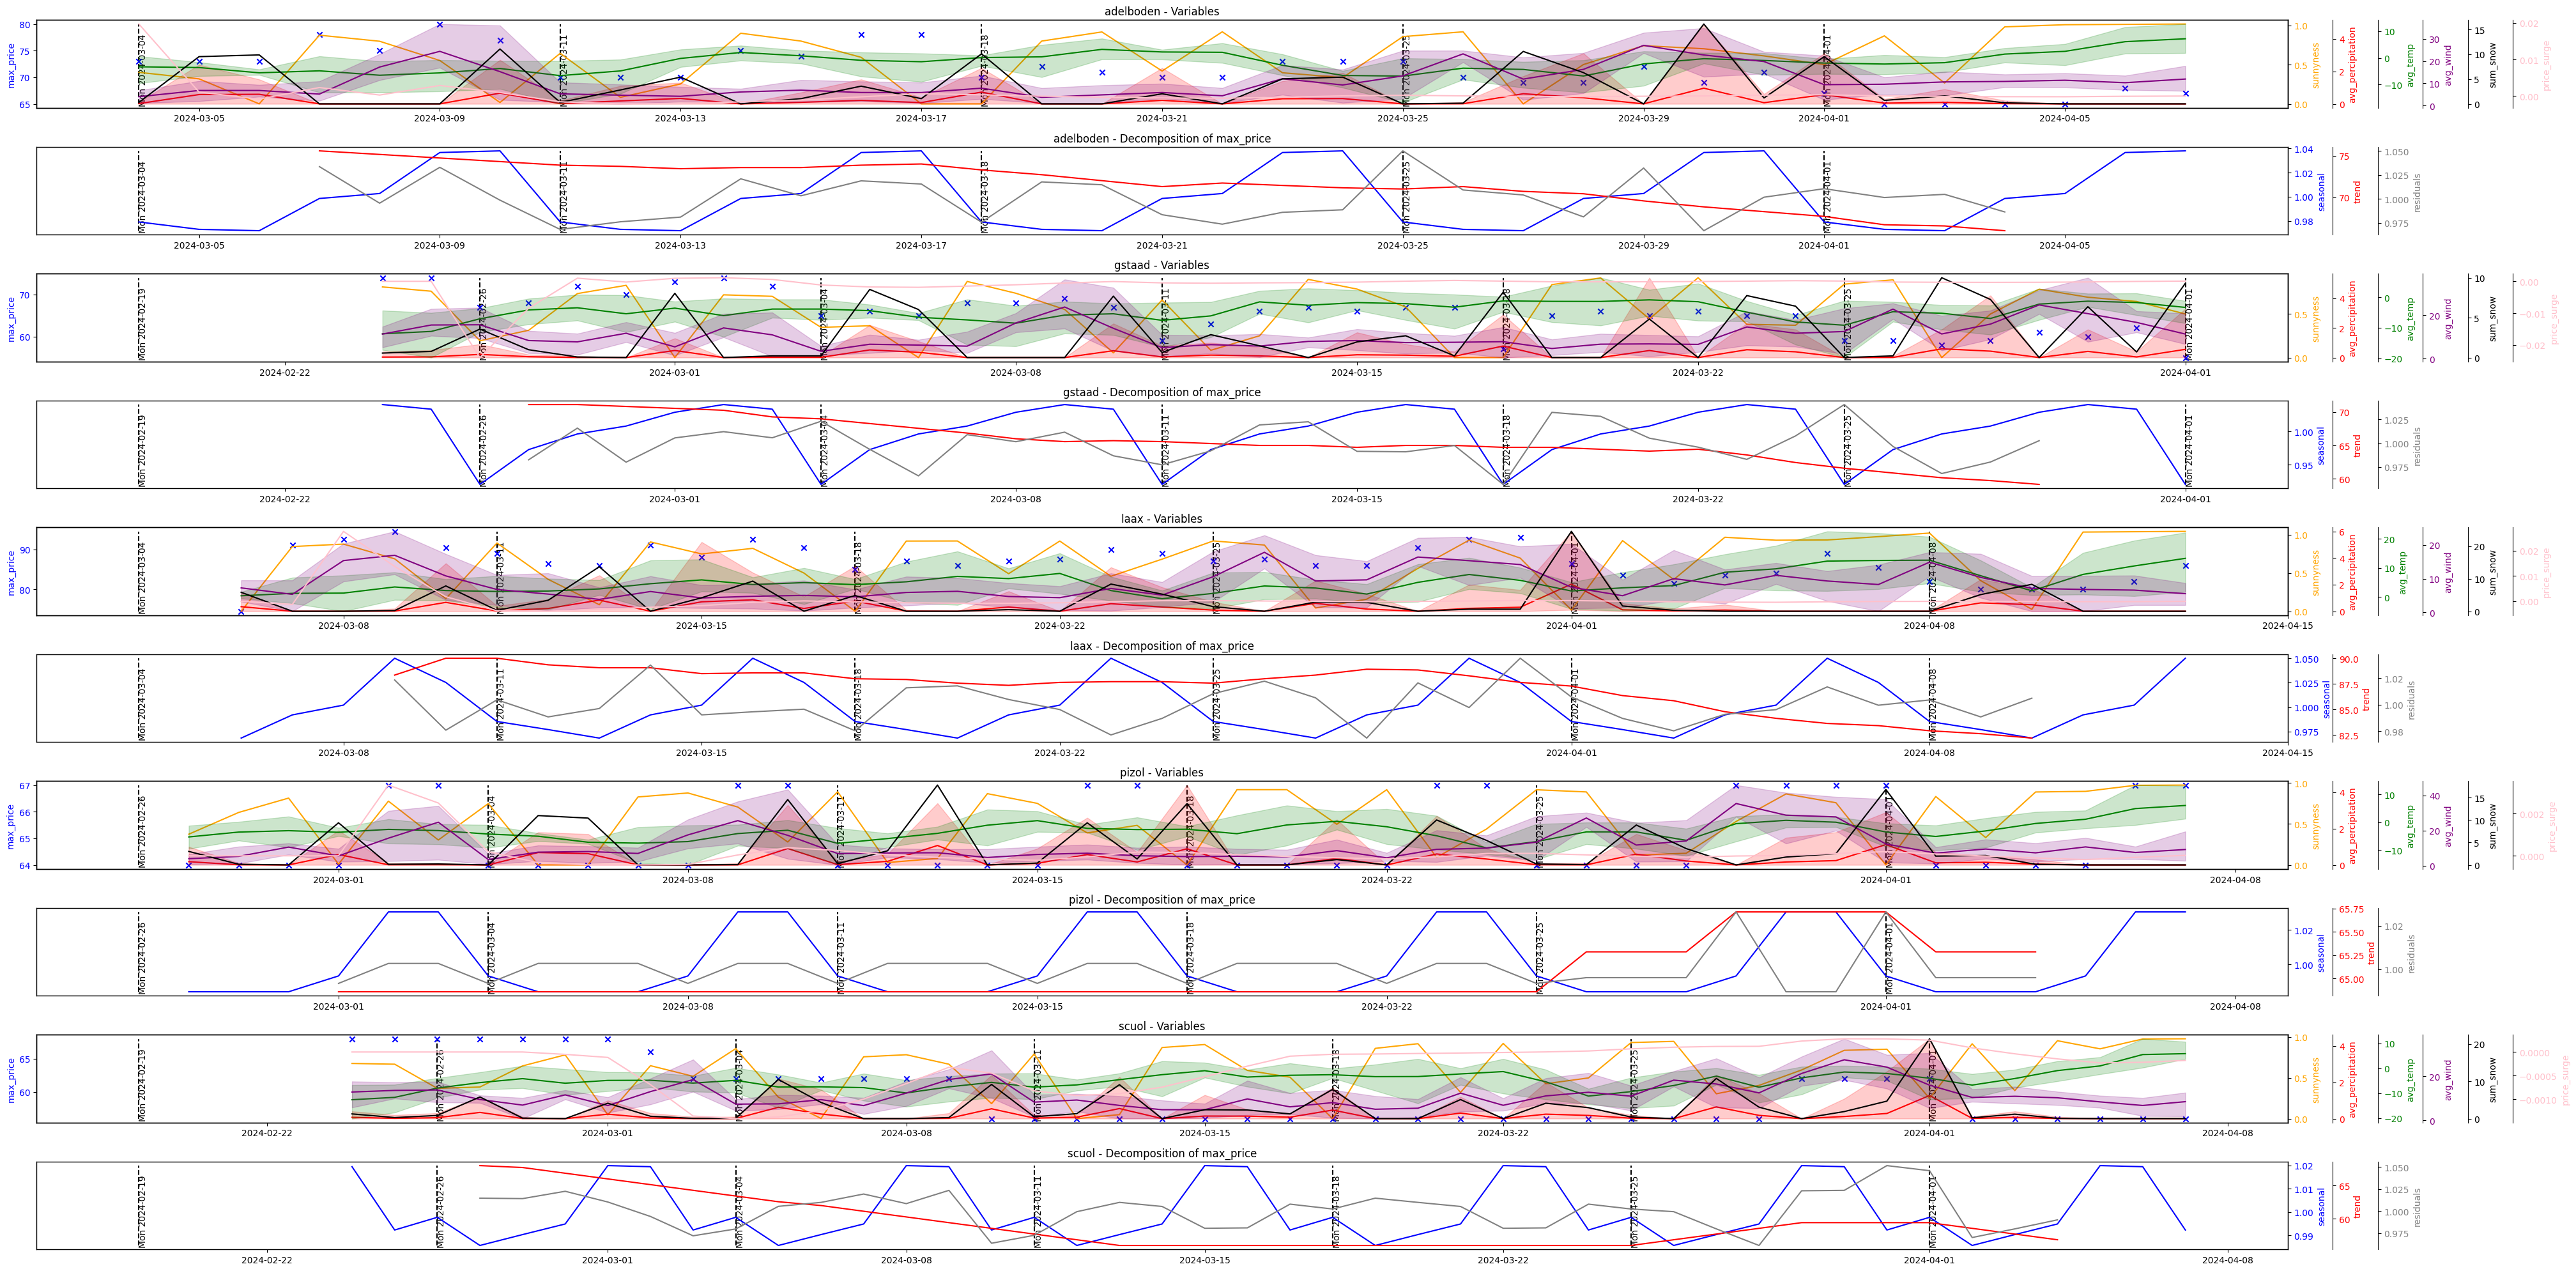

In [6]:
groups = ds.groupby("resort")

fig = plt.figure(figsize=(40, 20))        
for index, (resort, df) in enumerate(groups):
    axis = fig.add_subplot(
        2*len(groups.groups),1,2*index+1,
        yticks=[],
        title=f"{resort} - Variables"
    )
    add_axis_mondays(axis, df)

    for indx, (col, color, pltarea) in enumerate([
        ('max_price', 'blue', []),
        ('sunnyness', 'orange', []),
        ('avg_percipitation', 'red', ["max_percipitation", "min_percipitation"]),
        ('avg_temp', 'green', ["max_temp", "min_temp"]),
        ('avg_wind', 'purple', ["max_wind", "min_wind"]),
        ('sum_snow', 'black', []),
        ('price_surge', 'pink', []),
    ]):
        ax = axis.twinx()
        if indx > 0:
            ax.plot(df.index, df[col], color=color)
            if len(pltarea):
                ax.fill_between(df.index, df[pltarea[0]], df[pltarea[1]], color=color, alpha=.2)
            ax.set_yticks([])
            sax = ax.secondary_yaxis(1.0 + 0.02 * (indx - 1))
            sax.set_ylabel(col, color=color)
            sax.tick_params(axis='y', labelcolor=color)
        else:
            ax.scatter(df.index, df[col], color=color, marker='x')
            ax.yaxis.set_ticks_position("left")
            ax.yaxis.set_label_position("left")
            ax.set_ylabel(col, color=color)
            ax.tick_params(axis='y', labelcolor=color)


    decomp_m = seasonal_decompose(np.array(df['max_price']), period = 7, model = 'multiplicative')
    df['seasonal'] = decomp_m.seasonal
    df['trend'] = decomp_m.trend
    df['residuals'] = decomp_m.resid
    axis_decomp = fig.add_subplot(
        2*len(groups.groups),1,2*index+2,
        yticks=[],
        title=f"{resort} - Decomposition of max_price"
    )
    add_axis_mondays(axis_decomp, df)
    for indx, (col, color, pltarea) in enumerate([
        ('seasonal', 'blue', []),
        ('trend', 'red', []),       
        ('residuals', 'grey', [])
    ]):
        ax = axis_decomp.twinx()
        ax.plot(df.index, df[col], color=color)
        if len(pltarea):
            ax.fill_between(df.index, df[pltarea[0]], df[pltarea[1]], color=color, alpha=.2)
        ax.set_yticks([])
        sax = ax.secondary_yaxis(1.0 + 0.02 * (indx))
        sax.set_ylabel(col, color=color)
        sax.tick_params(axis='y', labelcolor=color)

    

fig.tight_layout()
fig.show()

RMSE: 6.273590746409
RMSE: 6.363878387041911
RMSE: 5.638404460226251
RMSE: 1.4533145206761253
RMSE: 4.652581987614845


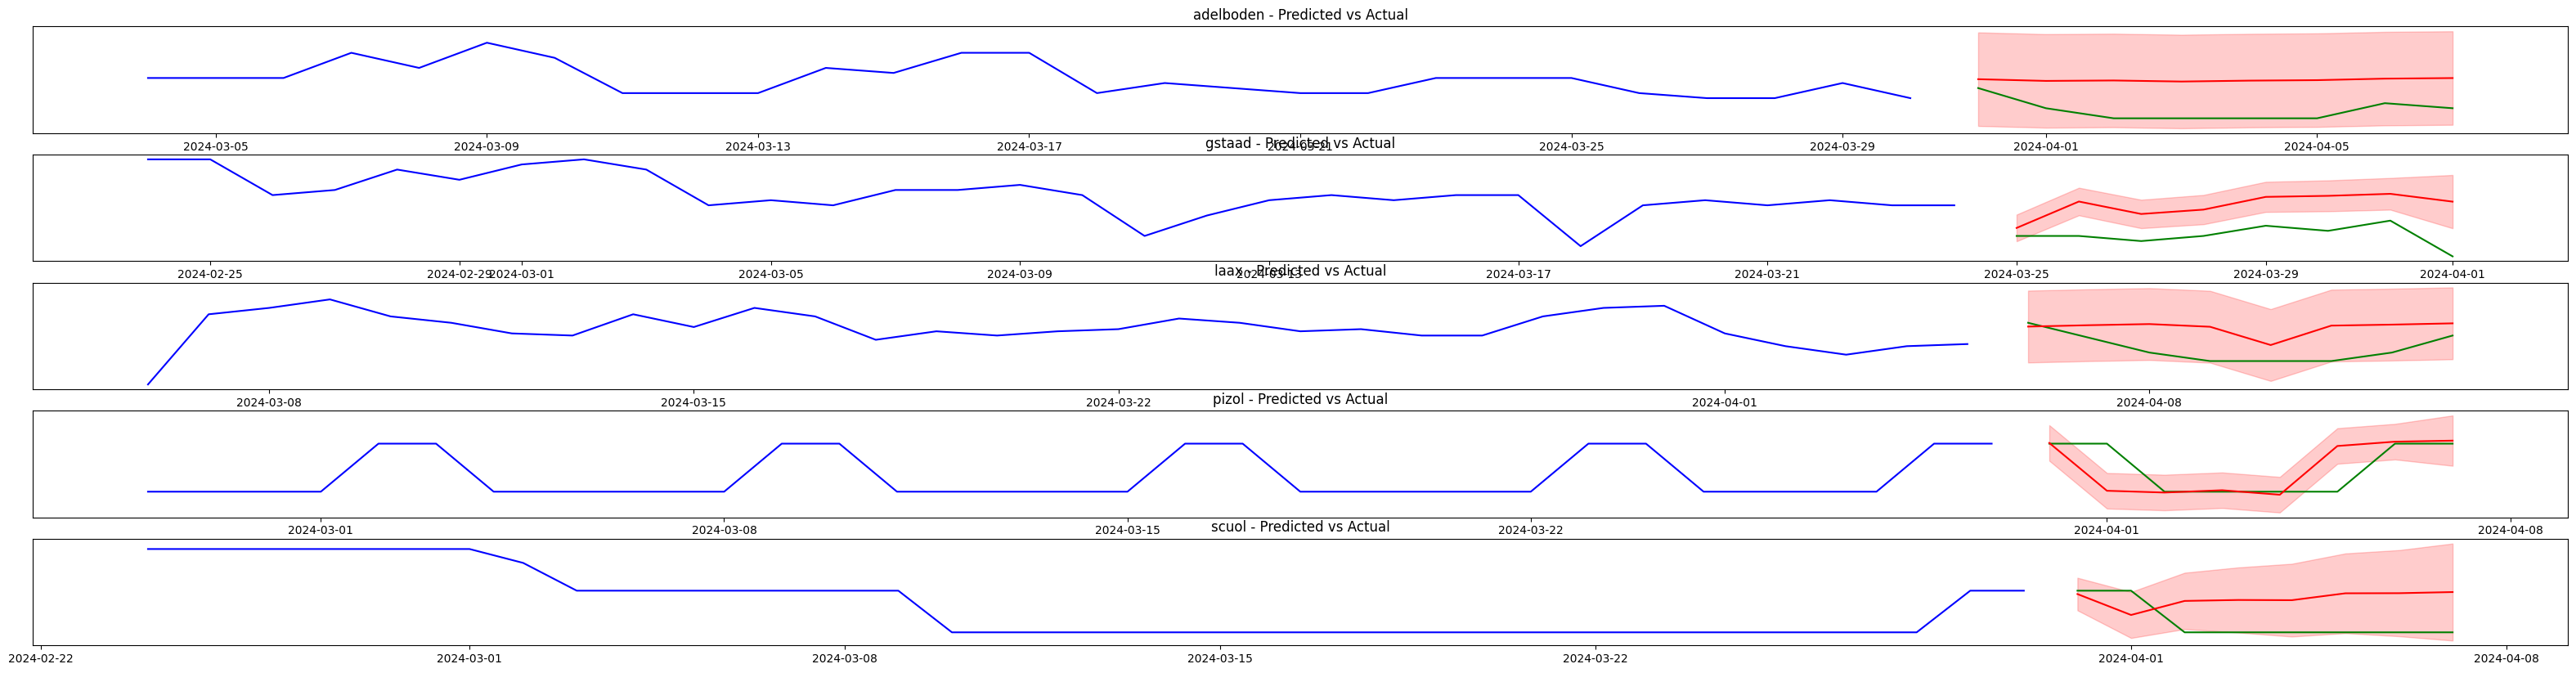

In [88]:
fig = plt.figure(figsize=(40, 20)) 
for index, (resort, df) in enumerate(groups):
    ds_prep = df[["max_price", "sunnyness", "avg_temp", "sum_snow", "avg_percipitation", "price_surge"]]
    cutoff = ds_prep.index[-1] - datetime.timedelta(days=7) #"2024-03-22"
    X_train, X_test = ds_prep.loc[ds_prep.index < cutoff].copy(), ds_prep.loc[ds_prep.index >= cutoff].copy()
    Y_train, Y_test = X_train["max_price"], X_test["max_price"]

    X_train.drop(columns=["max_price"], inplace=True)
    X_test.drop(columns=["max_price"], inplace=True)

    model_0 = auto_arima(y = Y_train, X = X_train, start_p = 0, d = None, start_q = 0, 
                        max_p = 4, max_d = 2, max_q = 4, 
                        start_P = 0, D = None, start_Q = 0, max_P = 3, max_D = 1, 
                        max_Q = 3, max_order = 8,
                        start_params = None,
                        stepwise = True, maxiter = 30,
                        m = 7, seasonal = True, stationary = False,
                        information_criterion = 'aic', 
                        alpha = 0.05, test = 'kpss', seasonal_test = 'ocsb',
                        with_intercept = 'auto', method = 'lbfgs',
                        suppress_warnings = True, error_action = 'trace', trace = False)


    model_p_0 = model_0.predict(n_periods = len(Y_test), X = X_test, return_conf_int = True)
    #print('Predicted:', list(zip(model_p_0[0], Y_test)))
    print('RMSE:', mean_squared_error(Y_test, model_p_0[0], squared = False))

    axis = fig.add_subplot(
        2*len(groups.groups),1,index+1,
        yticks=[],
        title=f"{resort} - Predicted vs Actual"
    )
    axis.plot(X_train.index, Y_train, color='blue')
    axis.plot(X_test.index, Y_test, color='green')
    axis.plot(X_test.index, model_p_0[0], color='red')
    axis.fill_between(X_test.index, model_p_0[1][:,0], model_p_0[1][:,1], color='red', alpha=.2)

In [10]:
import os
import platform
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.5.0-28-generic
Datetime: 2024-04-28 18:08:10
Python Version: 3.12.3
-----------------------------------
